# Task 2 : Symbolic, conditioned generation

# Section 1: Exploratory Analysis


## Context 
- This dataset comes from the Nottingham Dataset, which is 1034 folk melodies. It was initially in the form of ABC notations but converted to MIDI files and shared in a github repository (https://github.com/jukedeck/nottingham-dataset).
- We chose to work with this dataset since having split the music into melodies and working with folk songs, which have clearer structure and repeating motifs, allow us to more easily build models that can identify and reproduce these properties more easily.
- Because of this clear structure we thought this would be perfect for our extension models for task 2. 
## Discussion
- Data Processing: The only form of data processing we have done is trimming each song to be 20 seconds, to serve as our potential input files to test our models on. Besides this, we would use REMI tokenizers in our models for predictions. 
- Training data: We did not use the trimmed songs for training, instead we used all the files as a whole, so that the extension would have more success figuring out what comes next as it has far more data than the 20 second trims. 
## Code (Tables and Graphs): 

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import pretty_midi
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

%matplotlib inline

In [2]:
midi_dir = r"C:\Users\sugia\Desktop\UCSD\CSE 153\A2\melody"
midi_paths = glob.glob(os.path.join(midi_dir, "*.mid"))
print(f"Found {len(midi_paths)} MIDI files.")

Found 1034 MIDI files.


In [3]:
def get_midi_duration(path):
    pm = pretty_midi.PrettyMIDI(path)
    return pm.get_end_time()

In [4]:
durations = []
for path in tqdm(midi_paths[:100]):
    durations.append(get_midi_duration(path))

100%|██████████| 100/100 [00:00<00:00, 340.94it/s]


## Basic Statistics of our midi files

In [7]:
records = []
for path in tqdm(midi_paths):
    pm = pretty_midi.PrettyMIDI(path)
    duration = pm.get_end_time()

    all_notes = [note for inst in pm.instruments for note in inst.notes]
    total_notes = len(all_notes)
    if total_notes > 0:
        velocities = np.array([note.velocity for note in all_notes])
        unique_pitches = len({note.pitch for note in all_notes})
        avg_velocity = velocities.mean()
        note_density = total_notes / duration
    else:
        unique_pitches = 0
        avg_velocity = np.nan
        note_density = 0

    records.append({
        'file': os.path.basename(path),
        'duration_s': duration,
        'total_notes': total_notes,
        'unique_pitches': unique_pitches,
        'avg_velocity': avg_velocity,
        'num_instruments': len(pm.instruments),
        'note_density': note_density
    })

100%|██████████| 1034/1034 [00:04<00:00, 253.74it/s]


In [8]:
df = pd.DataFrame(records)
df.head()
df.describe()

,duration_s,total_notes,unique_pitches,avg_velocity,num_instruments,note_density
count,1034.000000,1034.000000,1034.000000,1034.0,1034.0,1034.000000
mean,67.317577,190.484526,11.130561,90.0,1.0,2.885537
std,44.901945,139.521282,2.461981,0.0,0.0,0.793271
min,11.000000,17.000000,4.000000,90.0,1.0,1.030769
25%,49.000000,126.000000,9.000000,90.0,1.0,2.293109
50%,64.000000,162.000000,11.000000,90.0,1.0,2.994035
75%,66.000000,214.000000,12.000000,90.0,1.0,3.440053
max,769.250000,2724.000000,21.000000,90.0,1.0,6.545455


In [9]:
df.nlargest(10, 'note_density')[['file', 'note_density', 'total_notes', 'duration_s']]

,file,note_density,total_notes,duration_s
31,ashover38.mid,6.545455,576,88.00
823,reelsm-q74.mid,6.272727,207,33.00
905,reelsr-t76.mid,6.204082,304,49.00
572,reelsa-c78.mid,6.167939,202,32.75
672,reelsh-l19.mid,5.907692,288,48.75
742,reelsh-l85.mid,5.842105,333,57.00
843,reelsr-t2.mid,5.836735,286,49.00
93,hpps52.mid,5.611940,188,33.50
24,ashover31.mid,5.437500,174,32.00
820,reelsm-q71.mid,5.312500,170,32.00


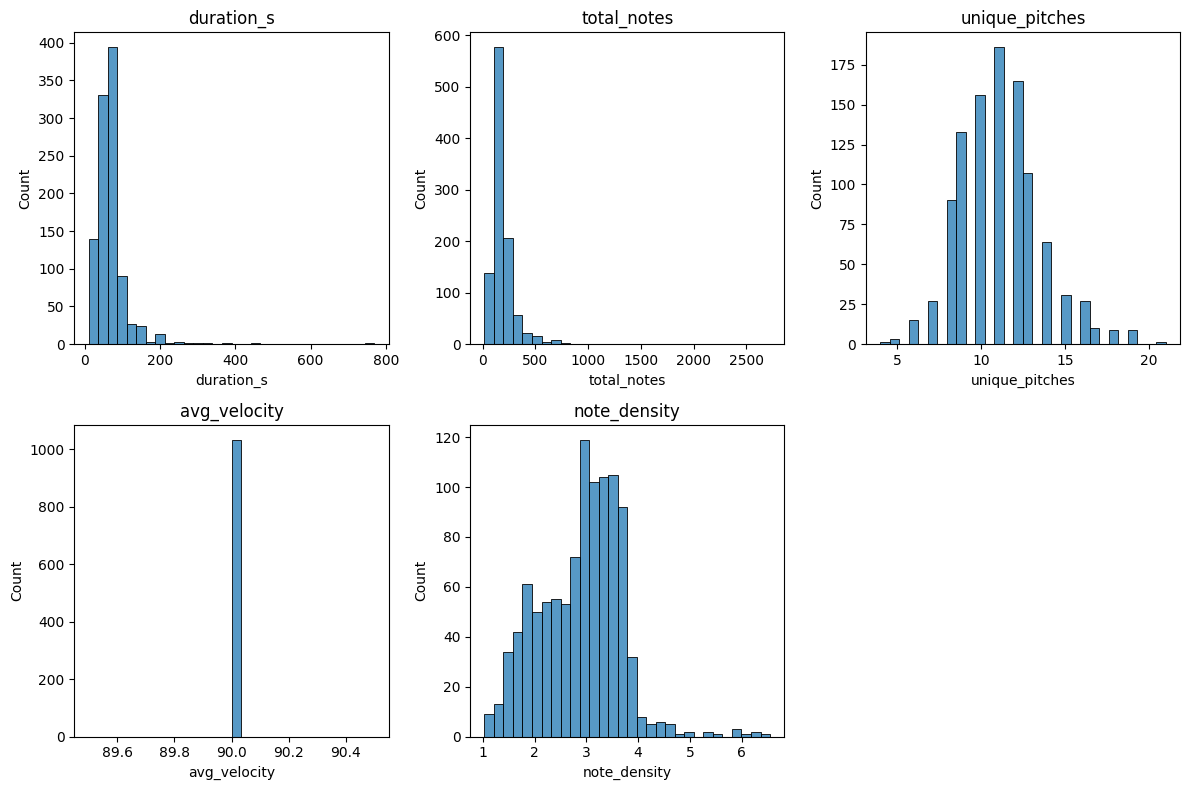

In [10]:
metrics = ['duration_s', 'total_notes', 'unique_pitches', 'avg_velocity', 'note_density']
plt.figure(figsize=(12, 8))
for i, m in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[m].dropna(), bins=30, kde=False)
    plt.title(m)
plt.tight_layout()
plt.show()

## Statistics to note:
- Most songs are around the 60-100 seconds range.
- The mean for notes is around 200 notes per song.
- There is a normal distribution for unique pitches across the songs with a mean of 11.
- all the music is played at 90 velocity, so they are equally loud.
- The note density is quite varied between 1-4 but a majority are in the 3-4 range. 

## More Specific Data

In [11]:
ext_records = []
for path in tqdm(midi_paths):
    pm = pretty_midi.PrettyMIDI(path)
    # Polyphony: sample time grid for active note counts
    times = np.linspace(0, pm.get_end_time(), num=500)
    active_counts = [sum(1 for inst in pm.instruments for note in inst.notes if note.start <= t < note.end) for t in times]
    max_poly = int(max(active_counts))
    avg_poly = float(np.mean(active_counts))

    # Tempo
    tempo_changes, tempi = pm.get_tempo_changes()
    mean_tempo = float(np.mean(tempi)) if len(tempi)>0 else np.nan
    tempo_range = float(np.max(tempi)-np.min(tempi)) if len(tempi)>1 else 0.0

    # Key and time signature events
    key_sigs = [ks.key_number for ks in pm.key_signature_changes]
    time_sigs = [(ts.numerator, ts.denominator) for ts in pm.time_signature_changes]
    key_mode = key_sigs[0] if key_sigs else None
    time_sig = time_sigs[0] if time_sigs else (None, None)

    # Note durations and IOIs
    note_durs = np.array([note.end-note.start for inst in pm.instruments for note in inst.notes])
    ioi = np.diff([note.start for inst in pm.instruments for note in inst.notes])
    dur_q = np.quantile(note_durs, [0.25, 0.5, 0.75]) if note_durs.size>0 else [np.nan]*3
    ioi_mean = float(np.mean(ioi)) if ioi.size>0 else np.nan
    ioi_var = float(np.var(ioi)) if ioi.size>0 else np.nan

    # Pitch-class histogram
    pitches = [note.pitch % 12 for inst in pm.instruments for note in inst.notes]
    pc_hist = np.bincount(pitches, minlength=12)
    pc_hist_norm = pc_hist / pc_hist.sum() if pc_hist.sum()>0 else pc_hist

    ext_records.append({
        'file': os.path.basename(path),
        'max_polyphony': max_poly,
        'avg_polyphony': avg_poly,
        'mean_tempo_bpm': mean_tempo,
        'tempo_range_bpm': tempo_range,
        'key_signature': key_mode,
        'time_signature': f"{time_sig[0]}/{time_sig[1]}",
        'dur_q1': dur_q[0], 'dur_q2': dur_q[1], 'dur_q3': dur_q[2],
        'ioi_mean': ioi_mean, 'ioi_var': ioi_var,
        **{f'pc_{i}': pc_hist_norm[i] for i in range(12)}
    })

100%|██████████| 1034/1034 [00:09<00:00, 110.22it/s]


,file,max_polyphony,avg_polyphony,mean_tempo_bpm,tempo_range_bpm,key_signature,time_signature,dur_q1,dur_q2,dur_q3,...,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,pc_11
count,1034,1034.000000,1034.000000,1034.0,1034.0,1034.000000,1034,1034.000000,1034.000000,1034.000000,...,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000
unique,1034,NaN,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,xmas9.mid,NaN,NaN,NaN,NaN,NaN,4/4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,537,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.023211,0.981619,120.0,0.0,4.863636,NaN,0.280241,0.321466,0.409776,...,0.170172,0.003364,0.139066,0.016678,0.108730,0.134715,0.010336,0.168427,0.009041,0.129192
std,NaN,0.179929,0.056638,0.0,0.0,3.066506,NaN,0.091143,0.127407,0.183532,...,0.069314,0.012904,0.065236,0.045660,0.075455,0.087893,0.024652,0.064112,0.034299,0.067723
min,NaN,1.000000,0.780000,120.0,0.0,0.000000,NaN,0.125000,0.125000,0.125000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,1.000000,0.972000,120.0,0.0,2.000000,NaN,0.250000,0.250000,0.250000,...,0.126787,0.000000,0.093209,0.000000,0.047811,0.069581,0.000000,0.125000,0.000000,0.082023
50%,NaN,1.000000,0.974000,120.0,0.0,7.000000,NaN,0.250000,0.250000,0.500000,...,0.169315,0.000000,0.135593,0.000000,0.105263,0.131384,0.000000,0.163755,0.000000,0.129480
75%,NaN,1.000000,0.986000,120.0,0.0,7.000000,NaN,0.250000,0.500000,0.500000,...,0.211864,0.000000,0.183083,0.000000,0.166667,0.196973,0.006052,0.208333,0.000000,0.169540


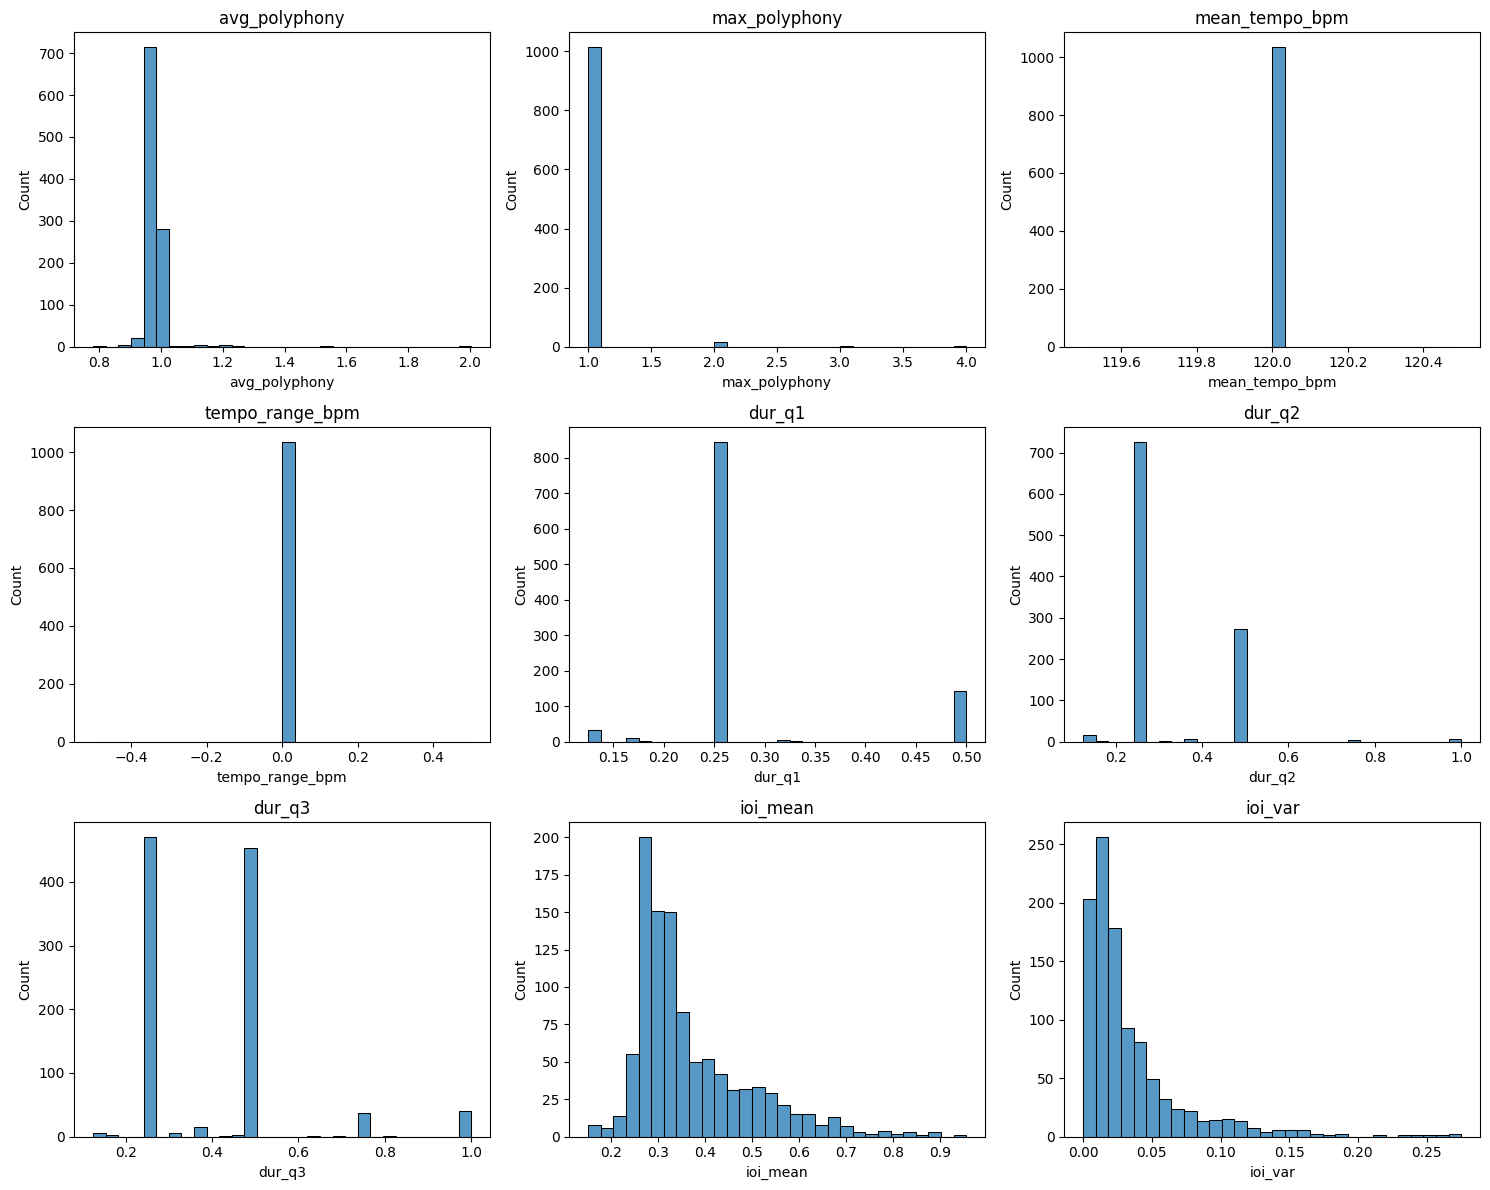

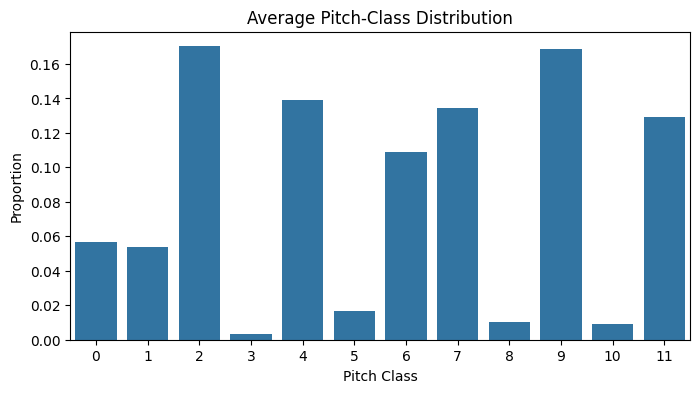

In [12]:
df_ext = pd.DataFrame(ext_records)
display(df_ext.describe(include='all'))

# Histogram plots for extended metrics
ext_metrics = [
    'avg_polyphony', 'max_polyphony',
    'mean_tempo_bpm', 'tempo_range_bpm',
    'dur_q1', 'dur_q2', 'dur_q3',
    'ioi_mean', 'ioi_var'
]
plt.figure(figsize=(15, 12))
for i, m in enumerate(ext_metrics, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_ext[m].dropna(), bins=30)
    plt.title(m)
plt.tight_layout()
plt.show()

# Average pitch-class distribution
pc_cols = [f'pc_{i}' for i in range(12)]
pc_mean = df_ext[pc_cols].mean()
plt.figure(figsize=(8, 4))
sns.barplot(x=list(range(12)), y=pc_mean.values)
plt.title('Average Pitch-Class Distribution')
plt.xlabel('Pitch Class')
plt.ylabel('Proportion')
plt.show()

## Statistics to Note
- Looking at the polyphony, it matches with the fact that our dataset is a set of monophonic melodies.
- The tempo also shows that every song is 120 BPM.
- The key and time signatures are also showing that it usually 4/4 bars and usually in D-Major.
- The durations show us that 25% of notes are less than 0.25 seconds, the median is 0.5 seconds, and 75% of notes are shorter than 0.75 seconds.  
- The inter-onset intervals are quite low, with a mean of 0.32 seconds.
- Pitch class distribution is showing that we have a lot of songs in the D, A, E and B major scale.  

# Processing the Data Trims

To reiterate this data trims are for the inputs we use to test our models, while we will still train on the whole dataset. 

In [13]:
trimmed_dir = os.path.join(midi_dir, 'trimmed_20s')
os.makedirs(trimmed_dir, exist_ok=True)

for path in tqdm(midi_paths):
    pm = pretty_midi.PrettyMIDI(path)
    trimmed_pm = pretty_midi.PrettyMIDI()
    trimmed_pm.instruments = []
    for inst in pm.instruments:
        new_inst = pretty_midi.Instrument(program=inst.program,
                                          is_drum=inst.is_drum,
                                          name=inst.name)
        for note in inst.notes:
            if note.start < 20.0:
                new_end = min(note.end, 20.0)
                new_inst.notes.append(pretty_midi.Note(
                    velocity=note.velocity,
                    pitch=note.pitch,
                    start=note.start,
                    end=new_end
                ))
        trimmed_pm.instruments.append(new_inst)
    trimmed_pm.write(os.path.join(trimmed_dir, os.path.basename(path)))

100%|██████████| 1034/1034 [00:07<00:00, 145.24it/s]


# Section 2: Modeling 
1. Context
- Our ML task is to create models that will take in MIDI files and generate an extension of those MIDI files, so that we can indefintely continue adding to the current piece.
- All of our models will take in the same input MIDI files and also output an extended version with an equal number of extended notes (although the time extension may differ due to how fast the notes are played)
- Appropriate models: We determined that our final model would be a learned sequence model, since  it can learn and take into account the entire piece for its extension. However, we also wanted to test it among simpler models such as our random baseline model and an extension of Markov Chain models that require far less power in exchange for not being able to account for the whole piece. 
- Optimizations: our first 2 models (Markov Chain) will focus on perplexity, while the third model (LSTM) optimizes its cross entropy loss while training. 

1. Discussion
- Baseline Model:
  - It is a random based trivial model that randomly picks notes to extend our base MIDI file.
  - Pros: 
    - No training, fast
  - Cons:
    - No musical structure at all
    - Terrible Perplexity
- Markov (No Seeding)
  - This markov model is trained over our whole dataset to learn the unigrams, bigrams, and trigrams of notes and beats. However it does not account for anything in the input MIDI file.
  - Pros
    - Simple implementation and fast production of output
    - The extended section will follow better musical structures learned in the dataset
  - Cons:
    - Can only learn short-context sequences to produce new notes
    - The musical structure may or may not differ from the original piece
- Markov (Seeding)
  - This markov model learns the unigrams, bigrams and trigrams similar to the previous. The difference is that it will learn the last few notes of the MIDI input file to match its musical structure in the extension. 
  - Pros:
    - Extension has similar musical structure to where the MIDI file ends
  - Cons: 
    - Still only learns short-context sequences
- LSTM 
  - This model is a stacked LSTM next token language model that learns the tokens from the REMI tokenizer.
    - Pros: 
      - Can learn very long-contexts for the extension
      - It can learn the rhythm and melody much better and account for when a change in rhythm is expected
    - Cons:
      - Complex, long training times
      - Can overfit and produce less unique music. 
- Complexity: LSTM is the most complex, followed by Markov then Random baselinee
- Efficiency: Random and Markov will train and produce extensions very quickly in a few seconds, while the LSTM took minutes to train
- Implementaiton challenges:
  - Random: Does not have a way to predict the rhythm and tempo at all
  - Markov: Can occassionally produce very different sounding music as it continues generating notes
  - LSTM: Hyper-parameters were difficult to tuen as it takes a long time to train the model.   

# Code Walk Through

# Imports


In [1]:
import os
import glob
import random
from collections import defaultdict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pretty_midi
import mido
from symusic import Score
from miditok import REMI, TokenizerConfig
from midiutil import MIDIFile
from tqdm import tqdm
setattr(np, 'int', int)

e:\miniconda3\envs\cse158\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}\n")

[INFO] Using device: cuda



In [3]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

# Setup and default functions

In [5]:
# Initial tokenization happening in this block
midi_files = glob.glob('MIDI/melody/*.mid')
len(midi_files)
config = TokenizerConfig(num_velocities=1, use_chords=False, use_programs=False)
tokenizer = REMI(config) 
tokenizer.train(vocab_size=1000, files_paths=midi_files)

In [6]:
random.seed(1)
random.shuffle(midi_files)
split = int(0.8 * len(midi_files))
train_files = midi_files[:split]
eval_files = midi_files[split:]

In [7]:
midi = Score(midi_files[0])
tokens = tokenizer(midi)[0].tokens
tokens[:10]

['Bar_None',
 'Position_20',
 'Pitch_74',
 'Velocity_127',
 'Duration_0.4.8',
 'Position_24',
 'Pitch_79',
 'Velocity_127',
 'Duration_0.4.8',
 'Position_28']

In [ ]:
def note_extraction(midi_file):
    score = Score(midi_file)
    tokens = tokenizer(score)[0].tokens
    pitches = [int(t.split('_')[1]) for t in tokens if t.startswith("Pitch_")]
    return pitches

def note_frequency(train_files):
    freq = defaultdict(int)
    for file in train_files:
        for pitch in note_extraction(file):
            freq[pitch] += 1
    return dict(freq)

def note_unigram_probability(train_files):
    note_counts = note_frequency(train_files)
    totalNotes = sum(note_counts.values())
    unigramProbabilities = {note : count/ totalNotes for note, count in note_counts.items()}

    
    return unigramProbabilities

def note_bigram_probability(train_files):

    bigramTransitions = defaultdict(list)
    bigramTransitionProbabilities = defaultdict(list)

    bigramCounts = defaultdict(lambda: defaultdict(int))
    for file in train_files:
        pitches = note_extraction(file)
        for i, j in zip(pitches, pitches[1:]):
            bigramCounts[i][j] += 1

    T = {}
    P = {}
    for prev, next in bigramCounts.items():
        nextNotes = list(next.keys())
        counts = list(next.values())
        total = sum(counts)
        prob = [c/total for c in counts]
        bigramTransitions[prev] = nextNotes
        bigramTransitionProbabilities[prev] =  prob 

    

    return bigramTransitions, bigramTransitionProbabilities

def sample_next_note(note):
    bigramTransitions, bigramTransitionProbabilities = note_bigram_probability(train_files)
    next = bigramTransitions.get(note)
    probs = bigramTransitionProbabilities.get(note)
    return random.choices(next, weights=probs, k=1)[0]

def note_trigram_probability(train_files):
    trigramTransitions = defaultdict(list)
    trigramTransitionProbabilities = defaultdict(list)
    
    trigram_counts = defaultdict(lambda: defaultdict(int))
    for file in train_files:
        pitch = note_extraction(file)
        for i in range(2, len(pitch)):
            note = (pitch[i-2], pitch[i-1])
            trigram_counts[note][pitch[i]] += 1
    for note, next_dict in trigram_counts.items():
        notes  = list(next_dict.keys())
        counts = list(next_dict.values())
        total  = sum(counts)
        probs  = [c/total for c in counts]

        trigramTransitions[note] = notes
        trigramTransitionProbabilities[note] = probs

    return trigramTransitions, trigramTransitionProbabilities

duration2length = {
    '0.2.8': 2,  # sixteenth note, 0.25 beat in 4/4 time signature
    '0.4.8': 4,  # eighth note, 0.5 beat in 4/4 time signature
    '1.0.8': 8,  # quarter note, 1 beat in 4/4 time signature
    '2.0.8': 16, # half note, 2 beats in 4/4 time signature
    '4.0.4': 32, # whole note, 4 beats in 4/4 time signature
}

def beat_extraction(midi_file):
    score  = Score(midi_file)
    tokens = tokenizer(score)[0].tokens
    output = []

    for i, tok in enumerate(tokens):
        if tok.startswith("Position_"):
            position = int(tok.split("_",1)[1])

            if i+3 < len(tokens) and tokens[i+3].startswith("Duration_"):
                dur_str = tokens[i+3].split("_",1)[1]
                length = duration2length.get(dur_str, 0)

                if length > 0:
                    output.append((position, length))
    return output

def beat_bigram_probability(train_files):
    bigramBeatTransitions = defaultdict(list)
    bigramBeatTransitionProbabilities = defaultdict(list)
    counts = defaultdict(lambda: defaultdict(int))
    for file in train_files:
        beat = beat_extraction(file)
        lengths = [length for _,length in beat]
        for i,j in zip(lengths, lengths[1:]):
            counts[i][j] += 1
    for prev, next in counts.items():
        nextVal = list(next.keys())
        cnts = list(next.values())
        total = sum(cnts)
        probs = [c/total for c in cnts]
        bigramBeatTransitions[prev] = nextVal
        bigramBeatTransitionProbabilities[prev] = probs
    
    return bigramBeatTransitions, bigramBeatTransitionProbabilities

def beat_pos_bigram_probability(train_files):
    bigramBeatPosTransitions = defaultdict(list)
    bigramBeatPosTransitionProbabilities = defaultdict(list)
    
    counts = defaultdict(lambda: defaultdict(int))
    for file in train_files:
        for position, length in beat_extraction(file):
            counts[position][length] += 1

    
    for position, length in counts.items():
        vals  = list(length.keys())
        cnts  = list(length.values())
        total = sum(cnts)
        probs = [c/total for c in cnts]
        bigramBeatPosTransitions[position]= vals
        bigramBeatPosTransitionProbabilities[position] = probs

    return bigramBeatPosTransitions, bigramBeatPosTransitionProbabilities

def beat_trigram_probability(train_files):
    trigramBeatTransitions = defaultdict(list)
    trigramBeatTransitionProbabilities = defaultdict(list)

    trigram_counts = defaultdict(lambda: defaultdict(int))
    for file in train_files:
        beats = beat_extraction(file)
        for (prev_pos, prev_len), (pos, length) in zip(beats, beats[1:]):
            pair = (prev_len, pos)
            trigram_counts[pair][length] += 1

    trigramBeatTransitions = {}
    trigramBeatTransitionProbabilities = {}
    for pair, next in trigram_counts.items():
        next_lengths = list(next.keys())
        counts = list(next.values())
        total = sum(counts)
        probs = [c/total for c in counts]
        trigramBeatTransitions[pair] = next_lengths
        trigramBeatTransitionProbabilities[pair] = probs
    return trigramBeatTransitions, trigramBeatTransitionProbabilities

# Baseline Random Model

In [ ]:
def extend_random_midi(
    in_path: str,
    out_path: str,
    length: int = 100,
    track_idx: int = 1,
    channel: int = 0,
    velocity: int = 100
):
    # Load all the tracks
    mid   = mido.MidiFile(in_path)
    track = mid.tracks[track_idx]
    tpb   = mid.ticks_per_beat

    # remove only the final End-Of-Track
    if track and track[-1].is_meta and track[-1].type == "end_of_track":
        track.pop()

    # possible lengths in note grid
    choices_bl = [2, 4, 8, 16, 32]
    # Loop to get all the notes we want, runs length (number of notes to add) times
    for _ in range(length):
        pitch = random.randint(21, 108)
        bl    = random.choice(choices_bl)
        ticks = int((bl / 8.0) * tpb)
        # based on the random choice add the note on and offs with those values we picked above
        track.append(mido.Message(
            "note_on",
            note=pitch,
            velocity=velocity,
            time=0,
            channel=channel
        ))
        track.append(mido.Message(
            "note_off",
            note=pitch,
            velocity=0,
            time=ticks,
            channel=channel
        ))

    # re-add End-Of-Track and save
    track.append(mido.MetaMessage("end_of_track", time=0))
    mid.save(out_path)

In [10]:
extend_random_midi(
    "trimmed_20s/ashover4.mid",
    "ashover4_baseline_ext.mid",
    length=20,
    track_idx=1,
    channel=0,
    velocity=90
)

# Markov Chain Extension (No dependency on current MIDI) expansion 

In [ ]:
def generate_notes_and_beats(length):
    # generate the uni , bi, and trigrams of notes and beats here
    unigramProbabilities = note_unigram_probability(train_files)
    bigramTransitions, bigramTransitionProbabilities = note_bigram_probability(train_files)
    trigramTransitions, trigramTransitionProbabilities = note_trigram_probability(train_files)
    
    notes = []
    for i in range(length):
        # Choose first note from unigram
        if i == 0:
            next = list(unigramProbabilities.keys())
            weights= list(unigramProbabilities.values())
        elif i == 1:
            # Choose second note from bigram
            prev = notes[-1]
            next = bigramTransitions.get(prev, list(unigramProbabilities.keys()))
            weights= bigramTransitionProbabilities.get(prev, list(unigramProbabilities.values()))
        else:
            # choose every other note using trigrams
            prev2, prev1 = notes[-2], notes[-1]
            pair = (prev2, prev1)
            if pair in trigramTransitions:
                next, weights = trigramTransitions[pair], trigramTransitionProbabilities[pair]
            elif prev1 in bigramTransitions:
                next, weights = bigramTransitions[prev1], bigramTransitionProbabilities[prev1]
            else:
                next, weights = list(unigramProbabilities.keys()), list(unigramProbabilities.values())
        # Add the note we predict into our notes prediction array
        notes.append(random.choices(next, weights, k=1)[0])
    # generate bigrams for beat prediction    
    bigramBeatPosTransitions, bigramBeatPosTransitionProbabilities = beat_pos_bigram_probability(train_files)
    pos = 0
    beats = []
    # The way we choose the beats is basically the same as above for notes except we are using the bigrams for beats and positions
    for _ in range(length):
        next = bigramBeatPosTransitions.get(pos, [8]) 
        weights= bigramBeatPosTransitionProbabilities.get(pos, None)
        if weights is None:
            weights = [1]*len(next)
        bl = random.choices(next, weights, k=1)[0]
        beats.append(bl)
        pos = (pos + bl) % 32
    return notes, beats


# Function for generating the music
def extend_midi_unseeded(
    input_midi_path: str,
    output_midi_path: str,
    length: int,
    track_idx: int = 1,
    channel: int   = 0,
    velocity: int  = 100
):
    # load your base file
    mid = mido.MidiFile(input_midi_path)

    # pick the track you want to append to and remove its EndOfTrack
    track = mid.tracks[track_idx]
    track[:] = [msg for msg in track
                if not (msg.is_meta and msg.type == 'end_of_track')]

    # generate your notes + beats
    notes, beats = generate_notes_and_beats(length)

    # 4) append each new note
    for pitch, bl in zip(notes, beats):
        # convert your “beats” to delta-ticks
        dur_beats = bl / 8.0              # same scale you used in addNote()
        dur_ticks = int(dur_beats * mid.ticks_per_beat)

        # note_on at delta=0 (immediately after previous event)
        track.append(mido.Message('note_on',
                                  note=pitch,
                                  velocity=velocity,
                                  time=0,
                                  channel=channel))
        # note_off after dur_ticks
        track.append(mido.Message('note_off',
                                  note=pitch,
                                  velocity=0,
                                  time=dur_ticks,
                                  channel=channel))

    # finally close the track again
    track.append(mido.MetaMessage('end_of_track', time=0))

    # write out a brand-new file
    mid.save(output_midi_path)

In [12]:
extend_midi_unseeded("trimmed_20s/ashover4.mid", "ashover4_random_extended.mid", length=50)

# Markov Chain Extension + Seeding (Ensures reading context of the current MIDI) Expansion 

In [ ]:
def generate_notes_and_beats(length,unigramP, bigramT, bigramP,trigramT, trigramP,beat_pos_T, beat_pos_P,seed_pitches=None,seed_beats=None):
    # start with the seed from the midi file input
    notes = list(seed_pitches or [])
    beats = list(seed_beats   or [])

    # Figures out which notes to add based on the the usual uni, bi and trigrams from before but using context of where the original MIDI input ended
    for i in range(length):
       
        if len(notes) == 0:
            choices = list(unigramP.keys())
            weights = list(unigramP.values())
        elif len(notes) == 1:
            prev    = notes[-1]
            choices = bigramT.get(prev, list(unigramP.keys()))
            weights = bigramP.get(prev, list(unigramP.values()))
        else:
            prev2, prev1 = notes[-2], notes[-1]
            pair = (prev2, prev1)
            if pair in trigramT:
                choices = trigramT[pair]
                weights = trigramP[pair]
            else:
                choices = bigramT.get(prev1, list(unigramP.keys()))
                weights = bigramP.get(prev1, list(unigramP.values()))

        new_note = random.choices(choices, weights, k=1)[0]
        notes.append(new_note)

        # Beat generation just like in the previous model
        pos = sum(beats) % 32
        next_beats = beat_pos_T.get(pos, [8])
        next_wghts = beat_pos_P.get(pos, [1])
        new_bl = random.choices(next_beats, next_wghts, k=1)[0]
        beats.append(new_bl)

    return notes, beats

# 1) extract the last N seed notes & beats from an existing track
def extract_seed(input_midi_path, track_idx=1, n_seed=2):
    mid = mido.MidiFile(input_midi_path)
    ticks_per_beat = mid.ticks_per_beat
    track = mid.tracks[track_idx]

    time_cursor = 0
    active = {}       # note_on time for each pitch
    all_pitches = []
    all_beats   = []

    # This part extracts the last few notes and beats in the midi file
    for msg in track:
        time_cursor += msg.time
        # note-on
        if msg.type == 'note_on' and msg.velocity > 0:
            active[msg.note] = time_cursor
        # note-off
        elif (msg.type == 'note_off' or (msg.type=='note_on' and msg.velocity==0)) \
             and msg.note in active:
            start = active.pop(msg.note)
            dt = time_cursor - start
            # convert dt→your “beat units” (you used bl/8.0 earlier)
            bl = int((dt / ticks_per_beat) * 8)
            if bl <= 0:
                bl = 1
            all_pitches.append(msg.note)
            all_beats.append(bl)

    # take the last n_seed values
    seed_pitches = all_pitches[-n_seed:]
    seed_beats   = all_beats[-n_seed:]
    return seed_pitches, seed_beats

In [ ]:
def extend_with_continuation(in_path, out_path, length):
    # pull off the last two notes/beats as seed
    seed_n, seed_b = extract_seed(in_path, track_idx=1, n_seed=2)

    # precompute uni, bi, trigram and beat-pos bigrams exactly as before
    U   = note_unigram_probability(train_files)
    BT, BP = note_bigram_probability(train_files)
    TT, TP = note_trigram_probability(train_files)
    bPT, bPP = beat_pos_bigram_probability(train_files)

    # generate new events continuing from the seed
    notes, beats = generate_notes_and_beats(length,
                                            U, BT, BP,
                                            TT, TP,
                                            bPT, bPP,
                                            seed_pitches=seed_n,
                                            seed_beats=seed_b)

    # read notes, remove the EndOfTrack, append new notes, re-add EndOfTrack
    mid = mido.MidiFile(in_path)
    track = mid.tracks[1]
    track[:] = [m for m in track if not (m.is_meta and m.type=='end_of_track')]

    for pitch, bl in zip(notes[len(seed_n):], beats[len(seed_b):]):
        dur_ticks = int((bl/8.0) * mid.ticks_per_beat)
        track.append(mido.Message('note_on',  note=pitch, velocity=100, time=0,           channel=0))
        track.append(mido.Message('note_off', note=pitch, velocity=0,   time=dur_ticks, channel=0))

    track.append(mido.MetaMessage('end_of_track', time=0))
    mid.save(out_path)

In [14]:
extend_with_continuation("trimmed_20s/ashover4.mid", "ashover4_seeding_extended.mid", length=50)

# LSTM Model for Extension

In [15]:
# helper function to convert midi to token ids
def midi_to_token_ids(path, tokenizer):
    score  = Score(path)
    tokens = tokenizer(score)[0].tokens
    # look up each token in the tokenizer’s vocab
    return [tokenizer.vocab[t] for t in tokens]


# Our model
class REMILanguageModel(nn.Module):
    def __init__(self, vocab_size, emb_size=256, hidden=512, nlayers=2):
        super().__init__()
        # This is the token embedding layer
        # map REMI token to a vector size 256
        # used to learn pitch, duration and bar
        self.embed = nn.Embedding(vocab_size, emb_size)
        # 2 Stacked LSTM layers
        self.lstm  = nn.LSTM(emb_size, hidden, nlayers, batch_first=True)
        # Takes each LSTM hidden-vector and linearly maps
        # it back to `vocab_size` logits for next-token classification.
        self.fc    = nn.Linear(hidden, vocab_size)

    def forward(self, x, hidden=None):
        # x: [B, T] token-ids
        e, hidden = self.embed(x), hidden # embedding here
        out, hidden = self.lstm(e, hidden) # Run LSTM here
        logits = self.fc(out)        # Projecting outputs here
        return logits, hidden


In [16]:
# This section is responsible for the training of our model
class SeqDataset(Dataset):
    def __init__(self, data, seq_len=128):
        # data: a single long list of token-IDs
        self.v, self.L = torch.tensor(data), len(data)
        self.seq_len = seq_len

    def __len__(self):
        return (self.L - 1) // self.seq_len

    def __getitem__(self, i):
        i0 = i * self.seq_len
        x  = self.v[i0 : i0 + self.seq_len]
        y  = self.v[i0 + 1 : i0 + 1 + self.seq_len]
        return x, y

# assemble your corpus
all_ids_train = []
bar_id   = tokenizer.vocab["Bar_None"]

for f in train_files:
    all_ids_train.extend(midi_to_token_ids(f, tokenizer))
    all_ids_train.append(bar_id)
    
all_ids_eval = []
for f in eval_files:
    all_ids_eval.extend(midi_to_token_ids(f, tokenizer))
    all_ids_eval.append(bar_id)

train_ds = SeqDataset(all_ids_train, seq_len=256)
val_ds   = SeqDataset(all_ids_eval,   seq_len=256)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False, drop_last=True)


model = REMILanguageModel(tokenizer.vocab_size).to(device)
opt   = torch.optim.Adam(model.parameters(), 1e-3)
ce    = nn.CrossEntropyLoss()
# Training for 5 epochs currently and optimizes for cross entropy loss
for epoch in range(5):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        logits, _ = model(x)            # [B, T, V]
        loss = ce(logits.view(-1, logits.size(-1)),
                  y.view(-1))
        opt.zero_grad(); loss.backward()
        opt.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}: {total_loss/len(train_loader):.4f}")


Epoch 0: 1.9449
Epoch 1: 1.2695
Epoch 2: 0.9144
Epoch 3: 0.8295
Epoch 4: 0.7398


In [ ]:
def sample_from_model(model, seed_ids, device, length, top_k=5, temperature=1.0):
    model.eval()
    seq = seed_ids.copy()
    model = model.to(device)

    # Start generating the new tokens
    with torch.no_grad():
        hidden = None
        # prime with the seed (for context)
        for tok in seed_ids:
            inp = torch.tensor([[tok]], device=device)
            _, hidden = model(inp, hidden)

        for _ in range(length):
            # look at the last token to add to our overall context, then get the next one
            inp    = torch.tensor([[seq[-1]]], device=device)
            logits, hidden = model(inp, hidden)      # [1,1,vocab]
            logits = (logits[0, -1] / temperature)    # [vocab]
            # Get the top k highest logits and sample the highest probability  for us to append
            vals, idxs = torch.topk(logits, top_k)    # top logits
            probs      = F.softmax(vals, dim=0)       # top probabilities
            choice     = torch.multinomial(probs, 1)  # Sample the new choice
            new_id     = idxs[choice].item()
            seq.append(new_id) # Add the new token

    return seq


In [ ]:
# Parse the last 64 notes for context for how to start the extension
def extract_token_seed(path, tokenizer, n_seed=64):
    full_ids = midi_to_token_ids(path, tokenizer)
    # grab the final n_seed IDs
    return full_ids[-n_seed:]

# Modified note and beat extraction functions below for type checking, so that it runs on our LSTM model without issues.
def note_extraction(midi_or_tokens):
    # if someone passed in a bare list of tokens, just use it
    if isinstance(midi_or_tokens, list):
        tokens = midi_or_tokens
    else:
        # otherwise assume it's a file‐path or MidiFile and run Score()
        score  = Score(midi_or_tokens)
        tokens = tokenizer(score)[0].tokens

    pitches = [int(t.split("_",1)[1])
               for t in tokens
               if t.startswith("Pitch_")]
    return pitches

def beat_extraction(midi_or_tokens):
    if isinstance(midi_or_tokens, list):
        tokens = midi_or_tokens
    else:
        score  = Score(midi_or_tokens)
        tokens = tokenizer(score)[0].tokens

    output = []
    for i, tok in enumerate(tokens):
        if tok.startswith("Position_"):
            pos = int(tok.split("_",1)[1])
            # find the Duration_
            if i+3 < len(tokens) and tokens[i+3].startswith("Duration_"):
                dur_str = tokens[i+3].split("_",1)[1]
                bl      = duration2length.get(dur_str, 0)
                if bl > 0:
                    output.append((pos, bl))
    return output

id2token = {v:k for k,v in tokenizer.vocab.items()}

# Convert from tokens back into pitches and beats
def notes_beats_from_ids(ids: list[int]):
    
    # 1) decode into REMI tokens
    events = [id2token[i] for i in ids]

    # 2) fake‐up a minimal Score-like container for your old extractors
    class FakeScore:
        def __init__(self, tokens): self.tokens = tokens
    fake = FakeScore(events)

    # 3) reuse your existing functions
    pitches = note_extraction(fake.tokens)
    beats   = beat_extraction(events)
    return pitches, beats
# add the new notes to the original MIDI
def extend_midi_seeded(
    in_path: str,
    out_path: str,
    new_pitches: list[int],
    new_beats:   list[int],
    track_idx:  int = 1,
    channel:    int = 0,
    velocity:   int = 100
):
    mid   = mido.MidiFile(in_path)
    track = mid.tracks[track_idx]
    tpb   = mid.ticks_per_beat

    # drop only the final End of track
    if track and track[-1].is_meta and track[-1].type=="end_of_track":
        track.pop()
    # Append the new beats and notes again
    for p, bl in zip(new_pitches, new_beats):
        ticks = int((bl/8.0)*tpb)
        track.append(mido.Message("note_on",  note=p, velocity=velocity, time=0,      channel=channel))
        track.append(mido.Message("note_off", note=p, velocity=0,       time=ticks, channel=channel))

    track.append(mido.MetaMessage("end_of_track", time=0))
    mid.save(out_path)




In [ ]:
# Running everything to make the new file
if __name__ == "__main__":
    IN  = "trimmed_20s/ashover4.mid"
    OUT = "ashover4_lstm.mid"

    # grab the last 64 REMI-IDs as seed
    seed_ids = extract_token_seed(IN, tokenizer, n_seed=64)

    # sample 50 new IDs (adding 50 more notes)
    sampled = sample_from_model(model, seed_ids,  device, length=50,  top_k=5, temperature=1.0)

    # decode & extract pitch/beat
    new_p, new_b = notes_beats_from_ids(sampled)

    # append them onto your original MIDI
    lengths_only = [ length for (_pos, length) in new_b ]

    extend_midi_seeded(
        IN,
        OUT,
        new_p,          
        lengths_only,   
        track_idx=1,
        channel=0
    )
    print("Wrote →", OUT)

Wrote → ashover4_lstm.mid


## Task 4: Double LSTM

In [20]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

In [49]:
PITCH_DIM = 89  # 0-87 = A0-C8, 88 = rest
REST_TOKEN = 88

DURATIONS = [0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 4.0,
             0.125, 0.333, 1/6, 1/3, 2.5, 5.0, 6.0, 8.0, 12.0, 16.0, 24.0]
DUR_DIM = len(DURATIONS)

DUR_TO_IDX = {d: i for i, d in enumerate(DURATIONS)}

def quantize_duration(d):
    # map a duration to nearest token index
    dists = [abs(d - q) for q in DURATIONS]
    return int(np.argmin(dists))

def quantize_duration_in_beats(pm: pretty_midi.PrettyMIDI, dur_seconds: float) -> int:
    # grab the first tempo in the file:
    tempo_times, tempi_bpm = pm.get_tempo_changes()
    tempo_bpm = float(tempi_bpm[0])
    sec_per_beat = 60.0 / tempo_bpm

    # convert from seconds to beats:
    beats = dur_seconds / sec_per_beat

    # find the closest entry in DURATIONS:
    dists = [abs(beats - q) for q in DURATIONS]
    return int(np.argmin(dists))

In [50]:
class MelodyDataset(Dataset):
    def __init__(self, file_list, seq_len=32):
        self.seq_len = seq_len
        self.examples = []  # list of (pitch_seq, dur_seq)
        for f in file_list:
            pm = pretty_midi.PrettyMIDI(f)
            # assume first instrument track
            inst = pm.instruments[0]
            notes = sorted(inst.notes, key=lambda n: n.start)
            pitches, durs = [], []
            for n in notes:
                pitches.append(n.pitch)
                durs.append(n.end - n.start)
            # convert rest if gap > small threshold
            # here assume no rests for simplicity
            # quantize
            pitches = [p if p < 88 else REST_TOKEN for p in pitches]
            dur_idxs = [
                quantize_duration_in_beats(pm, dur_seconds=d)
                for d in durs
            ]

            # split into subsequences
            for i in range(len(pitches) - seq_len):
                x_p = pitches[i : i + seq_len]
                x_d = dur_idxs[i : i + seq_len]
                y_p = pitches[i + 1 : i + seq_len + 1]
                y_d = dur_idxs[i + 1 : i + seq_len + 1]
                self.examples.append(((x_p, x_d), (y_p, y_d)))
    def __len__(self):
        return len(self.examples)
    def __getitem__(self, idx):
        (x_p, x_d), (y_p, y_d) = self.examples[idx]
        return (torch.LongTensor(x_p), torch.LongTensor(x_d)), (torch.LongTensor(y_p), torch.LongTensor(y_d))

In [51]:
setattr(np, 'int', int)

SEQ_LEN = 32
BATCH_SIZE = 64
train_ds = MelodyDataset(train_files, seq_len=SEQ_LEN)
eval_ds = MelodyDataset(eval_files, seq_len=SEQ_LEN)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
eval_loader = DataLoader(eval_ds, batch_size=BATCH_SIZE)

In [ ]:
# embed pitch (or duration) and condition embedding
# concatenate and encode -> LSTM -> decoder
class InterCondLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, cond_vocab_size, cond_embed_dim,
                 output_dim, hidden_dim=256, seq_len=32, batch_size=64,
                 dropout=0.2, batch_norm=True, no_cuda=False):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = 2
        self.batch_norm = batch_norm
        self.no_cuda = no_cuda
        self.batch_size = batch_size
        # embeddings
        self.embedding      = nn.Embedding(vocab_size, embed_dim)
        self.cond_embedding = nn.Embedding(cond_vocab_size, cond_embed_dim)
        # encoder + BN over feature dim
        self.encoder    = nn.Linear(embed_dim + cond_embed_dim, hidden_dim)
        if batch_norm:
            self.encoder_bn = nn.BatchNorm1d(hidden_dim)
        # LSTM
        self.lstm = nn.LSTM(hidden_dim, hidden_dim,
                            num_layers=self.num_layers,
                            batch_first=True, dropout=dropout)
        # decoder + BN
        mid_dim = (hidden_dim + output_dim) // 2
        self.decode1   = nn.Linear(hidden_dim, mid_dim)
        if batch_norm:
            self.decode_bn = nn.BatchNorm1d(mid_dim)
        self.decode2   = nn.Linear(mid_dim, output_dim)
        self.softmax   = nn.LogSoftmax(dim=2)
        # init hidden/cell
        self.hidden_and_cell = None
        self.init_hidden_and_cell(batch_size)
        if torch.cuda.is_available() and not no_cuda:
            self.cuda()
    def init_hidden_and_cell(self, batch_size):
        h = torch.zeros(self.num_layers, batch_size, self.hidden_dim)
        c = torch.zeros(self.num_layers, batch_size, self.hidden_dim)
        if torch.cuda.is_available() and not self.no_cuda:
            h, c = h.cuda(), c.cuda()
        self.hidden_and_cell = (h, c)
    def forward(self, data):
        # x_embeds: pitch/dur vectors
        # cond_embeds: dur/pitch vectors
        # combine for conditioning
        x, conds = data
        x_embeds    = self.embedding(x)
        cond_embeds = self.cond_embedding(conds)
        enc = torch.cat([x_embeds, cond_embeds], dim=2)
        enc = self.encoder(enc)
        if self.batch_norm:
            # BN over feature dim: (N, C, L)
            enc = self.encoder_bn(enc.permute(0,2,1)).permute(0,2,1)
        enc = F.relu(enc)
        lstm_out, self.hidden_and_cell = self.lstm(enc, self.hidden_and_cell)
        dec = F.relu(self.decode1(lstm_out))
        if self.batch_norm:
            dec = self.decode_bn(dec.permute(0,2,1)).permute(0,2,1)
        dec = self.decode2(dec)
        return self.softmax(dec)

class PitchLSTM(InterCondLSTM):
    def __init__(self, **kwargs):
        super().__init__(vocab_size=PITCH_DIM, embed_dim=128,
                         cond_vocab_size=DUR_DIM, cond_embed_dim=32,
                         output_dim=PITCH_DIM, **kwargs)

class DurationLSTM(InterCondLSTM):
    def __init__(self, **kwargs):
        super().__init__(vocab_size=DUR_DIM, embed_dim=32,
                         cond_vocab_size=PITCH_DIM, cond_embed_dim=128,
                         output_dim=DUR_DIM, **kwargs)

In [57]:
pitch_model = PitchLSTM(seq_len=SEQ_LEN, batch_size=BATCH_SIZE)
dur_model = DurationLSTM(seq_len=SEQ_LEN, batch_size=BATCH_SIZE)
optimizer_p = torch.optim.Adam(pitch_model.parameters(), lr=1e-3)
optimizer_d = torch.optim.Adam(dur_model.parameters(), lr=1e-3)
criterion = nn.NLLLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.cuda.empty_cache()
pitch_model.to(device)
dur_model.to(device)

EPOCHS = 8
for epoch in range(1, EPOCHS+1):
    pitch_model.train(); dur_model.train()
    total_loss_p, total_loss_d = 0.0, 0.0
    for (x_p, x_d), (y_p, y_d) in train_loader:
        # move inputs and targets to device
        x_p, x_d = x_p.to(device), x_d.to(device)
        y_p, y_d = y_p.to(device), y_d.to(device)
        # reset hidden state per batch
        pitch_model.init_hidden_and_cell(x_p.size(0))
        dur_model.init_hidden_and_cell(x_d.size(0))
        # forward pass
        out_p = pitch_model((x_p, x_d))
        out_d = dur_model((x_d, x_p))
        # compute loss
        loss_p = criterion(out_p.view(-1, PITCH_DIM), y_p.view(-1))
        loss_d = criterion(out_d.view(-1, DUR_DIM), y_d.view(-1))
        # backward and optimize
        optimizer_p.zero_grad(); optimizer_d.zero_grad()
        (loss_p + loss_d).backward()
        optimizer_p.step(); optimizer_d.step()
        total_loss_p += loss_p.item()
        total_loss_d += loss_d.item()
    print(f"Epoch {epoch}: Pitch Loss={total_loss_p/len(train_loader):.4f}, Dur Loss={total_loss_d/len(train_loader):.4f}")

torch.save(pitch_model.state_dict(), "pitch_model.pt")
torch.save(dur_model.state_dict(),   "dur_model.pt")

Using device: cuda
Epoch 1: Pitch Loss=1.0903, Dur Loss=0.4908
Epoch 2: Pitch Loss=0.4458, Dur Loss=0.1836
Epoch 3: Pitch Loss=0.3636, Dur Loss=0.1416
Epoch 4: Pitch Loss=0.3347, Dur Loss=0.1285
Epoch 5: Pitch Loss=0.3176, Dur Loss=0.1213
Epoch 6: Pitch Loss=0.3055, Dur Loss=0.1161
Epoch 7: Pitch Loss=0.2978, Dur Loss=0.1123
Epoch 8: Pitch Loss=0.2903, Dur Loss=0.1096


In [22]:
pitch_model = PitchLSTM(seq_len=SEQ_LEN, batch_size=BATCH_SIZE)
dur_model   = DurationLSTM(seq_len=SEQ_LEN, batch_size=BATCH_SIZE)

pitch_model.load_state_dict(torch.load("pitch_model.pt",   map_location=device))
dur_model.load_state_dict(torch.load("dur_model.pt",     map_location=device))

pitch_model.to(device)
dur_model.to(device)

DurationLSTM(
  (embedding): Embedding(19, 32)
  (cond_embedding): Embedding(89, 128)
  (encoder): Linear(in_features=160, out_features=256, bias=True)
  (encoder_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(256, 256, num_layers=2, batch_first=True, dropout=0.2)
  (decode1): Linear(in_features=256, out_features=137, bias=True)
  (decode_bn): BatchNorm1d(137, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (decode2): Linear(in_features=137, out_features=19, bias=True)
  (softmax): LogSoftmax(dim=2)
)

In [ ]:
def generate_extension(pm, model_p, model_d, extend_len=32):
    notes = sorted(pm.instruments[0].notes, key=lambda n: n.start)
    seq_p = [n.pitch for n in notes]
    seq_d = [
        quantize_duration_in_beats(pm, dur_seconds=(n.end - n.start))
        for n in notes
    ]
    seed_p, seed_d = seq_p[-SEQ_LEN:], seq_d[-SEQ_LEN:]

    # reset LSTM hidden for batch=1
    model_p.init_hidden_and_cell(1)
    model_d.init_hidden_and_cell(1)
    model_p.eval(); model_d.eval()

    gen = []
    for _ in range(extend_len):
        ip = torch.LongTensor([seed_p]).to(device)
        idur = torch.LongTensor([seed_d]).to(device)

        # --- wrap inference in no_grad ---
        with torch.no_grad():
            logits_p = model_p((ip, idur)).squeeze(0)   # shape [seq_len, PITCH_DIM]
            logits_d = model_d((idur, ip)).squeeze(0)   # shape [seq_len, DUR_DIM]

        # now safe to call .cpu().numpy()
        probs_p = logits_p.cpu().numpy()
        probs_d = logits_d.cpu().numpy()

        next_p = int(probs_p[-1].argmax())
        next_d = int(probs_d[-1].argmax())

        gen.append((next_p, next_d))
        seed_p = seed_p[1:] + [next_p]
        seed_d = seed_d[1:] + [next_d]

    return gen

In [ ]:
os.makedirs('extended_t4',exist_ok=True)
for f in glob.glob('trimmed_20s/*.mid'):
    pm=pretty_midi.PrettyMIDI(f)
    ext=generate_extension(pm,pitch_model,dur_model,SEQ_LEN)
    inst=pm.instruments[0];end=max(n.end for n in inst.notes)
    for p,d in ext:
        dur=DURATIONS[d]
        inst.notes.append(pretty_midi.Note(100,p,end,end+dur));end+=dur
    out='extended_t4/'+os.path.basename(f)
    pm.write(out);print('Saved',out)


In [ ]:
os.makedirs('extended_t4_eval', exist_ok=True)
for orig in eval_files:
    trimmed = os.path.join('trimmed_20s', os.path.basename(orig))
    if not os.path.exists(trimmed):
        print(f"err: trimmed file not found: {trimmed}")
        continue

    pm = pretty_midi.PrettyMIDI(trimmed)
    ext = generate_extension(pm, pitch_model, dur_model, extend_len=SEQ_LEN)

    inst = pm.instruments[0]
    end_time = max(n.end for n in inst.notes)
    for pitch_token, dur_token in ext:
        dur = DURATIONS[dur_token]
        inst.notes.append(
            pretty_midi.Note(
                velocity=100,
                pitch=pitch_token,
                start=end_time,
                end=end_time + dur
            )
        )
        end_time += dur

    out_path = os.path.join('extended_t4_eval', os.path.basename(orig))
    pm.write(out_path)
    print(f"Saved extended MIDI (test): {out_path}")

# Task 3: Evaluation

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [30]:
unigramP = note_unigram_probability(train_files)
bigramT, bigramP = note_bigram_probability(train_files)
trigramT, trigramP = note_trigram_probability(train_files)
beatPosT, beatPosP = beat_pos_bigram_probability(train_files)

In [31]:
import numpy as np
import torch
import torch.nn.functional as F

In [32]:
k = 5

In [33]:
results = {
    'random':       {'nll': [], 'top_k': []},
    'markov_unseed':{'nll': [], 'top_k': []},
    'markov_seeded':{'nll': [], 'top_k': []},
    'lstm_lm':      {'nll': [], 'top_k': []},
    'double_lstm':  {'nll': [], 'top_k': []}
}

In [34]:
def extract_full_note_beat_sequences(midi_path):
    # use the same tokenizers 
    pitches = note_extraction(midi_path)                 # list[int]
    beat_pairs = beat_extraction(midi_path)              # list[(position, length)]
    beat_lengths = [length for (_, length) in beat_pairs]
    return pitches, beat_lengths

In [ ]:
# compute NLL over notes (unigram→bigram→trigram backoff) and beats (position‐bigram)
def eval_markov_unseeded(full_notes, full_beats, seed_notes, seed_beats):
    cont_notes = full_notes[len(seed_notes):]
    cont_beats = full_beats[len(seed_beats):]

    # --- NLL for notes ---
    nll_notes = 0.0
    for i, note in enumerate(cont_notes):
        if i == 0:
            p = unigramP.get(note, 1e-8)
            nll_notes -= np.log(p)
        elif i == 1:
            prev = cont_notes[0]
            if prev in bigramP:
                if note in bigramT[prev]:
                    idx = bigramT[prev].index(note)
                    p = bigramP[prev][idx]
                else:
                    p = unigramP.get(note, 1e-8)
            else:
                p = unigramP.get(note, 1e-8)
            nll_notes -= np.log(p)
        else:
            prev2, prev1 = cont_notes[i-2], cont_notes[i-1]
            pair = (prev2, prev1)
            if pair in trigramP and note in trigramT[pair]:
                idx = trigramT[pair].index(note)
                p = trigramP[pair][idx]
            else:
                if prev1 in bigramP and note in bigramT.get(prev1, []):
                    idx = bigramT[prev1].index(note)
                    p = bigramP[prev1][idx]
                else:
                    p = unigramP.get(note, 1e-8)
            nll_notes -= np.log(p)

    # --- NLL for beats ---
    nll_beats = 0.0
    pos = sum(seed_beats) % 32
    for length in cont_beats:
        if pos in beatPosP and length in beatPosT.get(pos, []):
            idx = beatPosT[pos].index(length)
            p = beatPosP[pos][idx]
        else:
            p = 1e-8
        nll_beats -= np.log(p)
        pos = (pos + length) % 32

    # --- Top-k accuracy for notes and beats ---
    hits, total = 0, 0

    # Notes top-k (unseeded starts with no history so history is cont_notes itself)
    for i, note in enumerate(cont_notes):
        if i == 0:
            choices = list(unigramP.keys())
            weights = list(unigramP.values())
        elif i == 1:
            prev = cont_notes[0]
            if prev in bigramT:
                choices = bigramT[prev]
                weights = bigramP[prev]
            else:
                choices = list(unigramP.keys())
                weights = list(unigramP.values())
        else:
            prev2, prev1 = cont_notes[i-2], cont_notes[i-1]
            pair = (prev2, prev1)
            if pair in trigramT:
                choices = trigramT[pair]
                weights = trigramP[pair]
            elif prev1 in bigramT:
                choices = bigramT[prev1]
                weights = bigramP[prev1]
            else:
                choices = list(unigramP.keys())
                weights = list(unigramP.values())

        # sort by weight descending
        idxs = np.argsort(weights)[::-1]
        topk_choices = {choices[j] for j in idxs[:k]}
        if note in topk_choices:
            hits += 1
        total += 1

    # Beats top-k
    pos = sum(seed_beats) % 32
    for length in cont_beats:
        if pos in beatPosT:
            choices = beatPosT[pos]
            weights = beatPosP[pos]
        else:
            choices = [length]
            weights = [1.0]
        idxs = np.argsort(weights)[::-1]
        topk_choices = {choices[j] for j in idxs[:k]}
        if length in topk_choices:
            hits += 1
        total += 1
        pos = (pos + length) % 32

    topk_acc = hits / total if total > 0 else 0.0
    return (nll_notes + nll_beats), topk_acc

In [ ]:
# same as unseeded but include seed context when computing NLL and top‐k
def eval_markov_seeded(full_notes, full_beats, seed_notes, seed_beats):
    cont_notes = full_notes[len(seed_notes):]
    cont_beats = full_beats[len(seed_beats):]

    # --- NLL for notes ---
    nll_notes = 0.0
    combined_notes = seed_notes + cont_notes
    for i_abs in range(len(seed_notes), len(combined_notes)):
        i = i_abs - len(seed_notes)
        note = combined_notes[i_abs]
        if i_abs == 0:
            p = unigramP.get(note, 1e-8)
        elif i_abs == 1:
            prev = combined_notes[0]
            if prev in bigramP and note in bigramT[prev]:
                idx = bigramT[prev].index(note)
                p = bigramP[prev][idx]
            else:
                p = unigramP.get(note, 1e-8)
        else:
            prev2, prev1 = combined_notes[i_abs-2], combined_notes[i_abs-1]
            pair = (prev2, prev1)
            if pair in trigramP and note in trigramT[pair]:
                idx = trigramT[pair].index(note)
                p = trigramP[pair][idx]
            else:
                if prev1 in bigramP and note in bigramT.get(prev1, []):
                    idx = bigramT[prev1].index(note)
                    p = bigramP[prev1][idx]
                else:
                    p = unigramP.get(note, 1e-8)
        nll_notes -= np.log(p)

    # --- NLL for beats ---
    nll_beats = 0.0
    pos = sum(seed_beats) % 32
    for length in cont_beats:
        if pos in beatPosP and length in beatPosT.get(pos, []):
            idx = beatPosT[pos].index(length)
            p = beatPosP[pos][idx]
        else:
            p = 1e-8
        nll_beats -= np.log(p)
        pos = (pos + length) % 32

    # --- Top-k accuracy for notes and beats ---
    hits, total = 0, 0
    combined_notes = seed_notes + cont_notes

    for i_abs in range(len(seed_notes), len(combined_notes)):
        note = combined_notes[i_abs]
        if i_abs == 0:
            choices = list(unigramP.keys())
            weights = list(unigramP.values())
        elif i_abs == 1:
            prev = combined_notes[0]
            if prev in bigramT:
                choices = bigramT[prev]
                weights = bigramP[prev]
            else:
                choices = list(unigramP.keys())
                weights = list(unigramP.values())
        else:
            prev2, prev1 = combined_notes[i_abs-2], combined_notes[i_abs-1]
            pair = (prev2, prev1)
            if pair in trigramT:
                choices = trigramT[pair]
                weights = trigramP[pair]
            elif prev1 in bigramT:
                choices = bigramT[prev1]
                weights = bigramP[prev1]
            else:
                choices = list(unigramP.keys())
                weights = list(unigramP.values())

        idxs = np.argsort(weights)[::-1]
        topk_notes = {choices[j] for j in idxs[:k]}
        if note in topk_notes:
            hits += 1
        total += 1

    pos = sum(seed_beats) % 32
    for length in cont_beats:
        if pos in beatPosT:
            choices = beatPosT[pos]
            weights = beatPosP[pos]
        else:
            choices = [length]
            weights = [1.0]
        idxs = np.argsort(weights)[::-1]
        topk_beats = {choices[j] for j in idxs[:k]}
        if length in topk_beats:
            hits += 1
        total += 1
        pos = (pos + length) % 32

    topk_acc = hits / total if total > 0 else 0.0
    return (nll_notes + nll_beats), topk_acc

In [ ]:
# prime the LM on trimmed tokens, then accumulate token NLL and top‐k hits for continuation
def eval_lstm_lm(full_midi, trimmed_midi):
    full_ids = midi_to_token_ids(full_midi, tokenizer)
    trim_ids = midi_to_token_ids(trimmed_midi, tokenizer)
    cont_ids = full_ids[len(trim_ids):]

    nll = 0.0
    hits = 0
    total = len(cont_ids)

    model.eval()
    hidden = None

    # prime with trimmed tokens
    for tok in trim_ids:
        inp = torch.tensor([[tok]], device=device)
        _, hidden = model(inp, hidden)

    prev_tok = trim_ids[-1] if trim_ids else 0
    for tok in cont_ids:
        inp = torch.tensor([[prev_tok]], device=device)
        logits, hidden = model(inp, hidden)         # [1,1,vocab]
        prob_dist = F.softmax(logits[0, -1], dim=0).detach().cpu().numpy()
        p = prob_dist[tok] if tok < prob_dist.shape[0] else 1e-8
        nll -= np.log(p + 1e-12)

        topk_idxs = torch.topk(logits[0, -1], k).indices.cpu().tolist()
        if tok in topk_idxs:
            hits += 1

        prev_tok = tok

    topk_acc = hits / total if total > 0 else 0.0
    return nll, topk_acc

In [ ]:
# for each continuation step: recompute pitch+duration window, run both LSTMs, sum NLL and top‐k
def eval_double_lstm(full_midi, trimmed_midi):
    pm_full = pretty_midi.PrettyMIDI(full_midi)
    inst_full = pm_full.instruments[0]
    notes_full = sorted(inst_full.notes, key=lambda n: n.start)
    full_pitches = [n.pitch if n.pitch < 88 else REST_TOKEN for n in notes_full]
    full_durs_raw = [n.end - n.start for n in notes_full]
    full_durs = [
        quantize_duration_in_beats(pm_full, dur_seconds=d)
        for d in full_durs_raw
    ]

    pm_trim = pretty_midi.PrettyMIDI(trimmed_midi)
    inst_trim = pm_trim.instruments[0]
    notes_trim = sorted(inst_trim.notes, key=lambda n: n.start)
    trim_pitches = [n.pitch if n.pitch < 88 else REST_TOKEN for n in notes_trim]
    trim_durs_raw = [n.end - n.start for n in notes_trim]
    trim_durs = [
        quantize_duration_in_beats(pm_trim, dur_seconds=d)
        for d in trim_durs_raw
    ]

    cont_pitches = full_pitches[len(trim_pitches):]
    cont_durs    = full_durs[len(trim_durs):]

    nll = 0.0
    hits = 0
    total = len(cont_pitches)

    pitch_model.eval()
    dur_model.eval()

    def build_window(seq, idx, pad_value):
        # pad_value must be a valid index for whichever embedding you're using
        if idx < SEQ_LEN:
            return [pad_value] * (SEQ_LEN - idx) + seq[:idx]
        else:
            return seq[idx - SEQ_LEN: idx]

    for i in range(len(cont_pitches)):
        abs_idx = len(trim_pitches) + i

        # produce rolling window of length SEQ_LEN, left‐pad if idx<SEQ_LEN
        # PAD PITCH WINDOW with REST_TOKEN for valid pitch‐embedding
        win_p = build_window(full_pitches, abs_idx, REST_TOKEN)

        # PAD DURATION WINDOW with 0 → valid for duration‐embedding (0 ≤ idx < DUR_DIM)
        win_d = build_window(full_durs,    abs_idx, 0)

        ip   = torch.LongTensor([win_p]).to(device)    # shape [1, SEQ_LEN]
        idur = torch.LongTensor([win_d]).to(device)    # shape [1, SEQ_LEN]

        # Re‐initialize hidden‐and‐cell so both LSTMs expect batch_size=1
        pitch_model.init_hidden_and_cell(1)
        dur_model.init_hidden_and_cell(1)

        with torch.no_grad():
            logits_p = pitch_model((ip, idur)).squeeze(0)  # [SEQ_LEN, PITCH_DIM]
            logits_d = dur_model((idur, ip)).squeeze(0)    # [SEQ_LEN, DUR_DIM]

        last_logits_p = logits_p[-1]
        last_logits_d = logits_d[-1]

        prob_p = torch.exp(last_logits_p).detach().cpu().numpy()
        prob_d = torch.exp(last_logits_d).detach().cpu().numpy()

        true_p = cont_pitches[i]
        true_d = cont_durs[i]

        p_p = prob_p[true_p] if (0 <= true_p < prob_p.shape[0]) else 1e-8
        p_d = prob_d[true_d] if (0 <= true_d < prob_d.shape[0]) else 1e-8

        nll -= (np.log(p_p + 1e-12) + np.log(p_d + 1e-12))

        topk_p = torch.topk(last_logits_p, k).indices.cpu().tolist()
        topk_d = torch.topk(last_logits_d, k).indices.cpu().tolist()
        if (true_p in topk_p) and (true_d in topk_d):
            hits += 1

    topk_acc = hits / total if total > 0 else 0.0
    return nll, topk_acc


In [ ]:
pitch_model = PitchLSTM(seq_len=SEQ_LEN, batch_size=BATCH_SIZE, batch_norm=True)
dur_model   = DurationLSTM(seq_len=SEQ_LEN, batch_size=BATCH_SIZE, batch_norm=True)
pitch_model.load_state_dict(torch.load("pitch_model.pt", map_location=device))
dur_model.load_state_dict(torch.load("dur_model.pt",   map_location=device))
pitch_model.to(device); dur_model.to(device)
pitch_model.eval(); dur_model.eval()

for model_name in results:
    results[model_name]['nll'].clear()
    results[model_name]['top_k'].clear()

# iterate evaluation set, extract trimmed/full sequences, and store metrics for all five models
for full_path in tqdm(eval_files):
    basename = os.path.basename(full_path)
    trimmed_path = os.path.join('trimmed_20s', basename)
    if not os.path.exists(trimmed_path):
        print(f"Trimmed file missing: {trimmed_path}")
        continue

    # Extract sequences
    full_notes, full_beats = extract_full_note_beat_sequences(full_path)
    trim_notes, trim_beats = extract_full_note_beat_sequences(trimmed_path)

    # ---- Random baseline ----
    cont_len = len(full_notes) - len(trim_notes)
    cont_beats_len = len(full_beats) - len(trim_beats)
    # Uniform over 88 pitches (21–108) and 5 possible beat-lengths [2,4,8,16,32]
    nll_random = cont_len * np.log(88) + cont_beats_len * np.log(5)
    # For uniform, top-k accuracy = k / V for notes and k / 5 for beats; approximate by averaging
    acc_random = 0.5 * (k / 88) + 0.5 * (k / 5)
    results['random']['nll'].append(nll_random)
    results['random']['top_k'].append(acc_random)

    # ---- Unseeded Markov ----
    nll_mu, topk_mu = eval_markov_unseeded(full_notes, full_beats, [], [])
    results['markov_unseed']['nll'].append(nll_mu)
    results['markov_unseed']['top_k'].append(topk_mu)

    # ---- Seeded Markov ----
    nll_ms, topk_ms = eval_markov_seeded(full_notes, full_beats, trim_notes, trim_beats)
    results['markov_seeded']['nll'].append(nll_ms)
    results['markov_seeded']['top_k'].append(topk_ms)

    # ---- LSTM Language Model ----
    nll_lm, topk_lm = eval_lstm_lm(full_path, trimmed_path)
    results['lstm_lm']['nll'].append(nll_lm)
    results['lstm_lm']['top_k'].append(topk_lm)

    # ---- Double-conditional LSTM ----
    nll_dl, topk_dl = eval_double_lstm(full_path, trimmed_path)
    results['double_lstm']['nll'].append(nll_dl)
    results['double_lstm']['top_k'].append(topk_dl)

100%|██████████| 207/207 [02:45<00:00,  1.25it/s]


In [59]:
for model_name, metrics in results.items():
    avg_nll = np.mean(metrics['nll']) if metrics['nll'] else float('nan')
    avg_topk = np.mean(metrics['top_k']) if metrics['top_k'] else float('nan')
    print(f"{model_name:20s} → Avg NLL: {avg_nll:.4f}, Avg Top-{k} Acc: {avg_topk:.4f}")

random               → Avg NLL: 829.3967, Avg Top-5 Acc: 0.5284
markov_unseed        → Avg NLL: 571.6043, Avg Top-5 Acc: 0.9123
markov_seeded        → Avg NLL: 406.2176, Avg Top-5 Acc: 0.9089
lstm_lm              → Avg NLL: 408.4848, Avg Top-5 Acc: 0.9421
double_lstm          → Avg NLL: 865.8251, Avg Top-5 Acc: 0.7863
